# CO2 Emissions Prediction

The global transportation sector is a major polluter and in 2020 produced approximately 7.3 billion metric tons of carbon dioxide (CO2) emissions. Passenger cars were the biggest source of emissions that year, accounting for 41 percent of global transportation emissions.

In recent decades, global CO2 emissions from passenger cars have increased and peaked at 3.2 billion metric tons in 2019. Car emissions fell in 2020, but this was only due to the COVID-19 pandemic. Medium and heavy trucks are the second- largest polluters, accounting for 22 percent of transportation emissions. Although this was half the emissions of passenger cars, there are considerably fewer trucks on the road, showing just how polluting global road freight is. In 2020, heavy-duty truck CO2 emissions totaled almost two billion metric tons.

#### Variables

<ol>
  <li>Make (string) - car producer</li>
  <li>Model (string) - car model</li>
  <li>Vehicle Class (string) - type of vehicle</li>
  <li>Engine Size(L) (float) - volume of engine</li>
  <li>Cylinders (integer) - number of cylinders</li>
  <li>Transmission (string) - type of transmission
    <ul>
      <li>A = Automatic</li>
      <li>AM = Automated manual</li>
      <li>AS = Automatic with select shift</li>
      <li>AV = Continuously variable</li>
      <li>M = Manual</li>
      <li>3 - 10 = Number of gears</li>
    </ul>
  </li>
  <li>Fuel Type (string)
    <ul>
      <li>X = Regular gasoline</li>
      <li>Z = Premium gasoline</li>
      <li>D = Diesel</li>
      <li>E = Ethanol (E85)</li>
      <li>N = Natural gas</li>
    </ul>
  </li>
  <li>Fuel Consumption City (L/100 km) (float)</li>
  <li>Fuel Consumption Hwy (L/100 km) (float)</li>
  <li>Fuel Consumption Comb (L/100 km) (float)</li>
  <li>Fuel Consumption Comb (mpg) (int)</li>
  <li>CO2 Emissions(g/km) (integer) - target variable</li>
</ol>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow import keras
from tqdm.keras import TqdmCallback

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('co2_emissions.csv')

In [3]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

There are 11 variables in this dataset with CO2 Emissions(g/km) as target variable.

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

## EDA

#### Check NULL values

In [6]:
df.isna().sum()

make                                0
model                               0
vehicle_class                       0
engine_size(l)                      0
cylinders                           0
transmission                        0
fuel_type                           0
fuel_consumption_city_(l/100_km)    0
fuel_consumption_hwy_(l/100_km)     0
fuel_consumption_comb_(l/100_km)    0
fuel_consumption_comb_(mpg)         0
co2_emissions(g/km)                 0
dtype: int64

There is no null values in this dataset.

In [7]:
categorical = [
    'make', 'model', 'vehicle_class', 'transmission', 'fuel_type'
]

numerical = [
    'engine_size(l)', 'cylinders', 'fuel_consumption_city_(l/100_km)', 
    'fuel_consumption_hwy_(l/100_km)', 'fuel_consumption_comb_(l/100_km)', 
    'fuel_consumption_comb_(mpg)'
]

#### Split datates into train/validation/test

Normally we perform EDA on df_full_train dataset. I split the data in 60% train / 20% validation / 20% test dataset.

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=13)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=13)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train['co2_emissions(g/km)'].values
y_train = df_train['co2_emissions(g/km)'].values
y_val = df_val['co2_emissions(g/km)'].values
y_test = df_test['co2_emissions(g/km)'].values

### Examine numerical features

In [10]:
df_full_train[numerical].describe()

,engine_size(l),cylinders,fuel_consumption_city_(l/100_km),fuel_consumption_hwy_(l/100_km),fuel_consumption_comb_(l/100_km),fuel_consumption_comb_(mpg)
count,5908.000000,5908.000000,5908.000000,5908.000000,5908.000000,5908.000000
mean,3.150254,5.606127,12.560782,9.047072,10.979926,27.463439
std,1.343718,1.817492,3.501702,2.229913,2.895802,7.217029
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000


Plot histograms with kernel density estimate to smooth the histogram, providing complementary information about the shape of the distribution. Plot box plots as well to understand outliers.

<AxesSubplot:xlabel='fuel_consumption_hwy_(l/100_km)'>

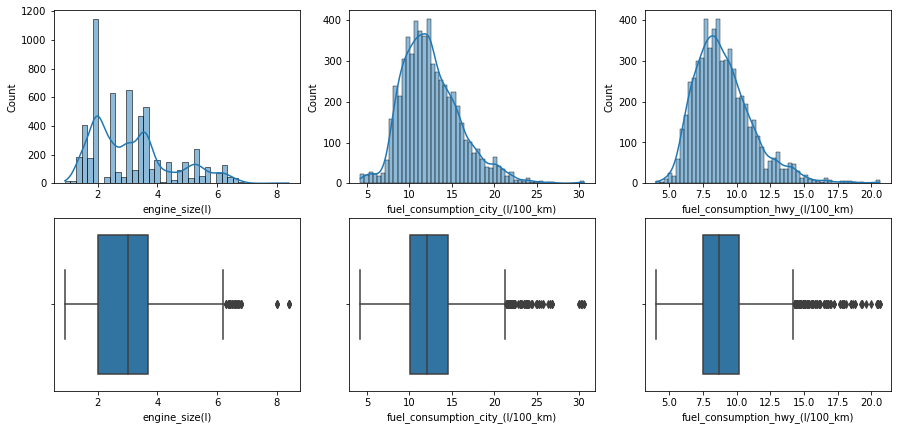

In [11]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
sns.histplot(data=df_full_train, x="engine_size(l)", kde=True, ax=axes[0, 0])
sns.histplot(data=df_full_train, x="fuel_consumption_city_(l/100_km)", kde=True, ax=axes[0, 1])
sns.histplot(data=df_full_train, x="fuel_consumption_hwy_(l/100_km)", kde=True, ax=axes[0, 2])
sns.boxplot(data=df_full_train, x="engine_size(l)", ax=axes[1, 0])
sns.boxplot(data=df_full_train, x="fuel_consumption_city_(l/100_km)", ax=axes[1, 1])
sns.boxplot(data=df_full_train, x="fuel_consumption_hwy_(l/100_km)", ax=axes[1, 2])

1. engine_size(l) feature is not normally distributed and right-skewed
2. fuel_consumption_city_(l/100_km) feature is close to normal distribution with skewed right
3. fuel_consumption_hwy_(l/100_km) feature is close to normal distribution with skewed right

This skewness to the right might be as the result of the outliers. The box plots under each feature proves this hypothesis: **engine_size(l)** with 8 litres seems as outlier as well as **fuel_consumption_city_(l/100_km)** feature with about 30 l/100_km.

<AxesSubplot:xlabel='cylinders'>

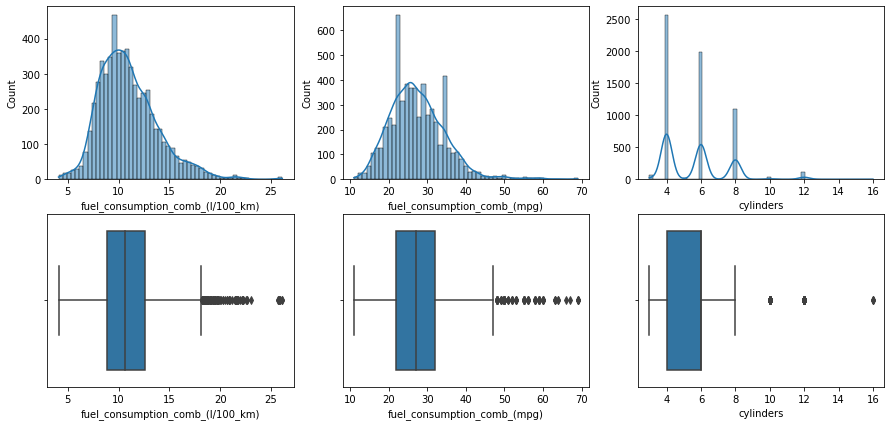

In [12]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
sns.histplot(data=df_full_train, x="fuel_consumption_comb_(l/100_km)", kde=True, ax=axes[0, 0])
sns.histplot(data=df_full_train, x="fuel_consumption_comb_(mpg)", kde=True, ax=axes[0, 1])
sns.histplot(data=df_full_train, x="cylinders", kde=True, ax=axes[0, 2])
sns.boxplot(data=df_full_train, x="fuel_consumption_comb_(l/100_km)", ax=axes[1, 0])
sns.boxplot(data=df_full_train, x="fuel_consumption_comb_(mpg)", ax=axes[1, 1])
sns.boxplot(data=df_full_train, x="cylinders", ax=axes[1, 2])

1. **fuel_consumption_comb_(l/100_km)** feature is is close to normally distributed and right-skewed
2. **fuel_consumption_comb_(mpg)** feature is close to normal distribution with skewed right
3. **cylinders** feature might be considered as categorical

This skewness to the right might be as the result of the outliers. The box plots under each feature proves this hypothesis: **fuel_consumption_comb_(l/100_km)** feature with more 25 l/100_km could be considered as outlier.

**How are numerical features correlated?**

In [13]:
df_full_train[numerical].corr()

,engine_size(l),cylinders,fuel_consumption_city_(l/100_km),fuel_consumption_hwy_(l/100_km),fuel_consumption_comb_(l/100_km),fuel_consumption_comb_(mpg)
engine_size(l),1.000000,0.927339,0.830037,0.761346,0.816093,-0.757543
cylinders,0.927339,1.000000,0.799405,0.714056,0.779192,-0.718321
fuel_consumption_city_(l/100_km),0.830037,0.799405,1.000000,0.948329,0.993798,-0.926023
fuel_consumption_hwy_(l/100_km),0.761346,0.714056,0.948329,1.000000,0.977419,-0.889425
fuel_consumption_comb_(l/100_km),0.816093,0.779192,0.993798,0.977419,1.000000,-0.924410
fuel_consumption_comb_(mpg),-0.757543,-0.718321,-0.926023,-0.889425,-0.924410,1.000000


<AxesSubplot:title={'center':'Pearson Correlation of Numerical Features'}>

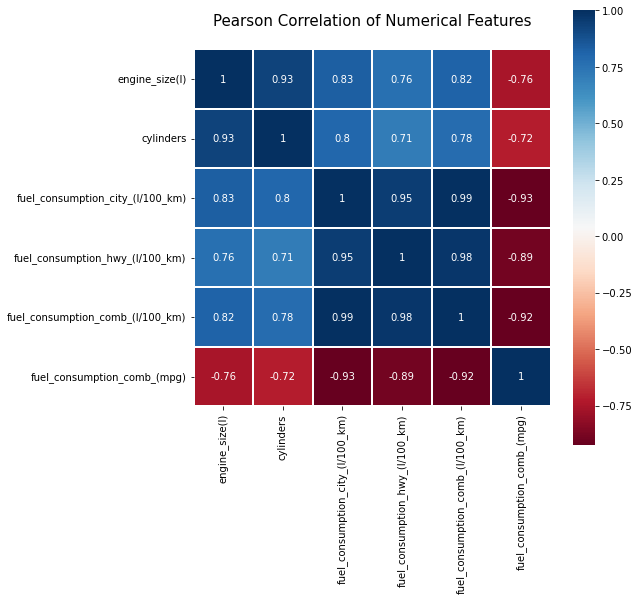

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(8, 8))
plt.title('Pearson Correlation of Numerical Features', y=1.05, size=15)
sns.heatmap(df_full_train[numerical].corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

As we may notice there is a high correlation between features which is not surprising given the nature of the features. In order to increase interpretability of the model I will use only **engine_size(l)**, **fuel_consumption_comb_(l/100_km)** and **fuel_consumption_comb_(mpg)** features.

### Examine categorical variables

In [15]:
df_full_train[categorical].nunique()

make               42
model            1927
vehicle_class      16
transmission       27
fuel_type           5
dtype: int64

There are a lot of variations in **make** (car producer) and **model**. In order to build a model with greater generalizing capability I will exclude these features from dataset during model training. 

#### **vehicle_class** categorical feature

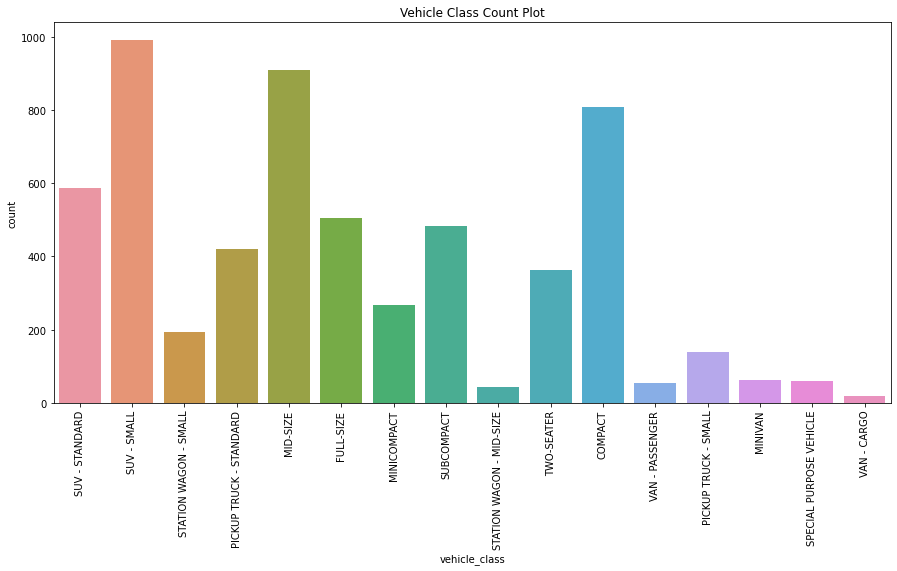

In [16]:
_, axes = plt.subplots(figsize=(15, 7))
sns.countplot(x='vehicle_class', data=df_full_train)
plt.xticks(rotation='vertical')
plt.title('Vehicle Class Count Plot')
plt.show()

It is noticable that vast majority of vehicle classes represented by *SUV-SMALL*, *MID-SIZE* and *COMPACT*.

#### **transmission** categorical feature

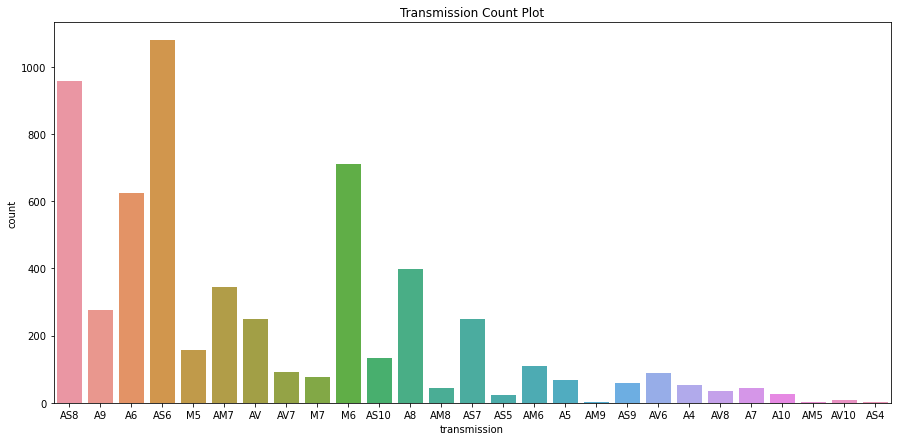

In [17]:
_, axes = plt.subplots(figsize=(15, 7))
sns.countplot(x='transmission', data=df_full_train)
plt.title('Transmission Count Plot')
plt.show()

Majority of the vehicles represented by *AS6*, *AS8*, *M6* type of transmission.

Let's examine type of transmission and number of gears separately

In [18]:
df_full_train['transmission_type'] = df_full_train['transmission'].apply(lambda row: re.split('\d+', row)[0])

/var/folders/83/dd1dp6cs4n5b8mt9sjqc20kh0000gn/T/ipykernel_1277/3374999283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_train['transmission_type'] = df_full_train['transmission'].apply(lambda row: re.split('\d+', row)[0])


In [19]:
df_full_train['transmission_gear'] = df_full_train['transmission'].apply(lambda row: re.split('[A-Z]+', row)[-1])

/var/folders/83/dd1dp6cs4n5b8mt9sjqc20kh0000gn/T/ipykernel_1277/809756074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_train['transmission_gear'] = df_full_train['transmission'].apply(lambda row: re.split('[A-Z]+', row)[-1])


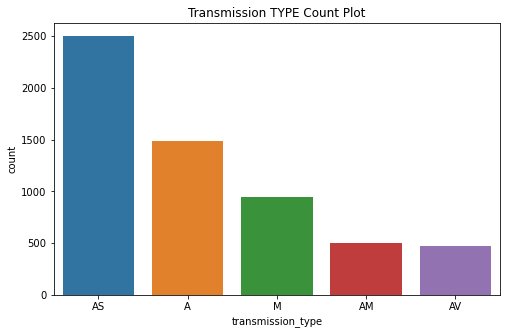

In [20]:
_, axes = plt.subplots(figsize=(8, 5))
sns.countplot(x='transmission_type', data=df_full_train)
plt.title('Transmission TYPE Count Plot')
plt.show()

The majority of the cars has AS (automatic with select shift transmission) transmission.

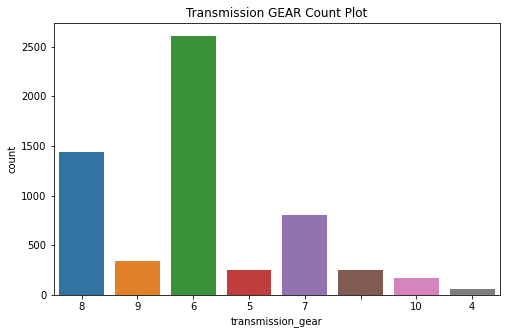

In [21]:
_, axes = plt.subplots(figsize=(8, 5))
sns.countplot(x='transmission_gear', data=df_full_train)
plt.title('Transmission GEAR Count Plot')
plt.show()

The majority of the cars has 6 and 8 gears. Some of the cars has transmission type of AV without mentioning number of gears.

#### **fuel_type** categorical feature

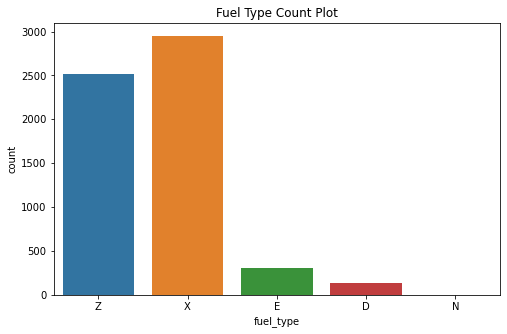

In [22]:
_, axes = plt.subplots(figsize=(8, 5))
sns.countplot(x='fuel_type', data=df_full_train)
plt.title('Fuel Type Count Plot')
plt.show()

Premium gasoline and regular gasoline are the main types of fuel used.

### Examine target variable CO2 Emissions

<AxesSubplot:xlabel='co2_emissions(g/km)'>

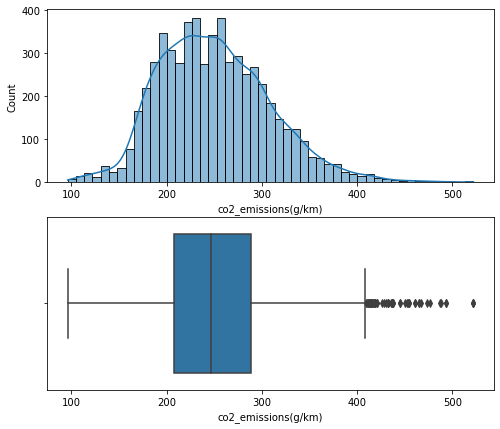

In [23]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 7))
sns.histplot(data=df_full_train, x="co2_emissions(g/km)", kde=True, ax=axes[0])
sns.boxplot(data=df_full_train, x="co2_emissions(g/km)", ax=axes[1])

Target variable close to normal distibution and slightly skewed to the right with couple of outliers. It might be helpful to apply log transformation to target variable during building the models.

<AxesSubplot:ylabel='Count'>

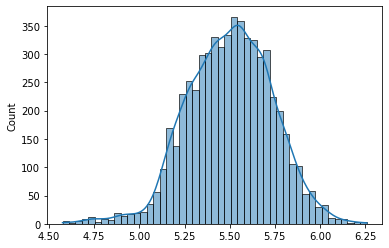

In [24]:
sns.histplot(np.log1p(y_full_train), kde=True)

**How selected numerical variables are correlated with target variable?**

<AxesSubplot:xlabel='fuel_consumption_comb_(mpg)'>

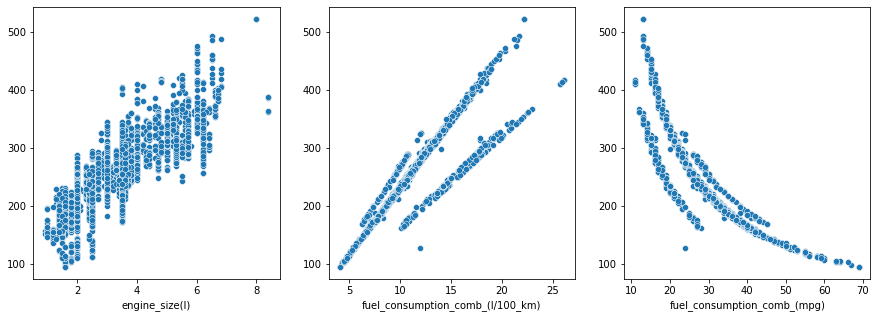

In [25]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.scatterplot(y=y_full_train, x=df_full_train['engine_size(l)'], ax=axes[0])
sns.scatterplot(y=y_full_train, x=df_full_train['fuel_consumption_comb_(l/100_km)'], ax=axes[1])
sns.scatterplot(y=y_full_train, x=df_full_train['fuel_consumption_comb_(mpg)'], ax=axes[2])

1. The direct correlation trend could be observed between **engine_size(l)** variable and target **co2_emissions(g/km)** variable
2. The direct correlation trend could be observed between **fuel_consumption_comb_(l/100_km)** variable and target **co2_emissions(g/km)** variable
3. An interesting observation, that behaviour of **fuel_consumption_comb_(mpg)** with respect to target variable **co2_emissions(g/km)** could be explained as hyperbolic decline

**How ALL numerical variables are correlated with target variable?**

In [26]:
df_full_train[numerical].corrwith(df_full_train['co2_emissions(g/km)'])

engine_size(l)                      0.850363
cylinders                           0.832167
fuel_consumption_city_(l/100_km)    0.916929
fuel_consumption_hwy_(l/100_km)     0.881566
fuel_consumption_comb_(l/100_km)    0.915626
fuel_consumption_comb_(mpg)        -0.906334
dtype: float64

**How categorical variables are related to target variable?**

In order to use ***mutual_info_score()*** function we need to turn our target numerical feature into categorical. 

In [27]:
q_emissions = pd.qcut(df_full_train['co2_emissions(g/km)'], q=10)

In [28]:
for cat in categorical:
    print(f'{cat} {mutual_info_score(df_full_train[cat], q_emissions):.4f}')

make 0.3889
model 1.8158
vehicle_class 0.3214
transmission 0.2702
fuel_type 0.0699


As expected **make** and **model** features show higher mututal info score compared to other categorical variables.

#### Selecting features

In [29]:
selected_f = [
    'vehicle_class', 'engine_size(l)', 'transmission', 'fuel_type', 
    'fuel_consumption_comb_(l/100_km)', 'fuel_consumption_comb_(mpg)'
]

### Preprocessing features

In [30]:
df_full_train = df_full_train[selected_f].reset_index(drop=True)
df_train = df_train[selected_f].reset_index(drop=True)
df_val = df_val[selected_f].reset_index(drop=True)
df_test = df_test[selected_f].reset_index(drop=True)

I will use MinMax scaler in order to scale numerical features within (0, 1) range.

In [31]:
scaler = MinMaxScaler()

In [32]:
df_train[['engine_size(l)', 
          'fuel_consumption_comb_(l/100_km)', 
          'fuel_consumption_comb_(mpg)']] = scaler.fit_transform(df_train[['engine_size(l)', 
                                                                           'fuel_consumption_comb_(l/100_km)', 
                                                                           'fuel_consumption_comb_(mpg)']])

In [33]:
df_val[['engine_size(l)', 
          'fuel_consumption_comb_(l/100_km)', 
          'fuel_consumption_comb_(mpg)']] = scaler.fit_transform(df_val[['engine_size(l)', 
                                                                           'fuel_consumption_comb_(l/100_km)', 
                                                                           'fuel_consumption_comb_(mpg)']])

Apply log transformation to the target variable

In [34]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

Use DictVectorizer to build binary one-hot encoding from features represented by string variables

In [35]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Build and Assess the models

### Linear Regression

In [36]:
lr_model = LinearRegression().fit(X_train, y_train)

lr_predict = lr_model.predict(X_val)

In [37]:
lr_rmse = round(mean_squared_error(y_val, lr_predict, squared=False), 4)
print(f'RMSE metric for Linear Regression: {lr_rmse}')

RMSE metric for Linear Regression: 0.0495


In [38]:
lr_score = round(lr_model.score(X_val, y_val), 3)
lr_score

0.957

### Ridge Regression

#### Baseline Model

In [39]:
rr_model = Ridge()
rr_model.fit(X_train, y_train)

rr_predict = rr_model.predict(X_val)

In [40]:
rr_rmse = round(mean_squared_error(y_val, rr_predict, squared=False), 4)
print(f'RMSE metric for baseline Ridge Regression: {rr_rmse}')

RMSE metric for baseline Ridge Regression: 0.048


In [41]:
rr_score = round(rr_model.score(X_val, y_val), 3)
rr_score

0.959

#### Hyperparameters tuning for Ridge Regression

In [42]:
scores = []

for a in (0.001, 0.01, 0.1, 0.5, 0.8, 1.0):
    rr_model = Ridge(alpha=a)
    rr_model.fit(X_train, y_train)

    rr_predict = rr_model.predict(X_val)
    
    rr_rmse = round(mean_squared_error(y_val, rr_predict, squared=False), 4)
    scores.append((a, rr_rmse))

In [43]:
columns = ['alpha_ridge', 'rmse']
df_scores_rr = pd.DataFrame(scores, columns=columns)
df_scores_rr

,alpha_ridge,rmse
0,0.001,0.0495
1,0.010,0.0495
2,0.100,0.0494
3,0.500,0.0487
4,0.800,0.0483
5,1.000,0.0480


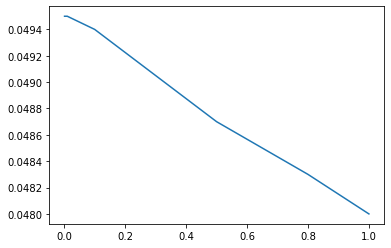

In [44]:
plt.plot(df_scores_rr.alpha_ridge, df_scores_rr.rmse)

In [45]:
rr_model = Ridge(alpha=a)
rr_model.fit(X_train, y_train)
rr_predict = rr_model.predict(X_val)
rr_rmse = round(mean_squared_error(y_val, rr_predict, squared=False), 4)
print(f'RMSE metric for best Ridge Regression: {rr_rmse}')

RMSE metric for best Ridge Regression: 0.048


### Random Forest Regressor

#### Baseline Model

In [46]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

rf_predict = rf_model.predict(X_val)

In [47]:
rf_rmse = round(mean_squared_error(y_val, rf_predict, squared=False), 4)
print(f'RMSE metric for baseline RF: {rf_rmse}')

RMSE metric for baseline RF: 0.0394


In [48]:
rf_score = round(rf_model.score(X_val, y_val), 3)
rf_score

0.973

#### Hyperparameters tuning for Random Forest Regressor

In [49]:
scores_rf = []

for d in [3, 5, 7, 10, 15]:
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=13,
                               n_jobs=-1,
                               warm_start=True)
    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        rf_predict = rf.predict(X_val)
        rf_rmse = round(mean_squared_error(y_val, rf_predict, squared=False), 4)
        scores_rf.append((d, n, rf_rmse))
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores_rf = pd.DataFrame(scores_rf, columns=columns)

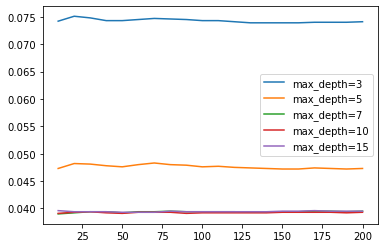

In [50]:
for d in [3, 5, 7, 10, 15]:
    df_subset = df_scores_rf[df_scores_rf.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')
plt.legend()

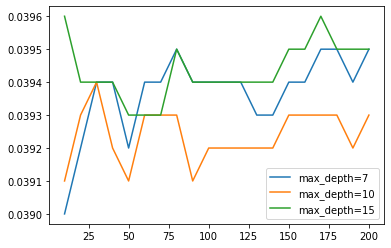

In [51]:
for d in [7, 10, 15]:
    df_subset = df_scores_rf[df_scores_rf.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth={d}')
plt.legend()

In [52]:
max_depth_rf = 10

In [53]:
scores_rf = []

for s in [1, 3, 5, 10, 50, 100, 200]:
    rf = RandomForestRegressor(n_estimators=0,
                                max_depth=max_depth_rf, 
                                min_samples_leaf=s,
                                random_state=13, 
                                n_jobs=-1,
                                warm_start=True)
    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        rf_predict = rf.predict(X_val)
        rf_rmse = round(mean_squared_error(y_val, rf_predict, squared=False), 4)
        scores_rf.append((s, n, rf_rmse))
columns = ['min_samples_leaf', 'n_estimators', 'rmse']
df_scores_rf = pd.DataFrame(scores_rf, columns=columns)

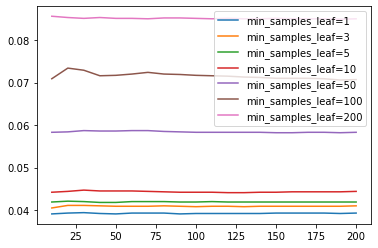

In [54]:
for s in [1, 3, 5, 10, 50, 100, 200]:
    df_subset = df_scores_rf[df_scores_rf.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'min_samples_leaf={s}')
plt.legend()

In [55]:
min_samples_leaf_rf = 1
n_estimators_rf = 25

In [56]:
rf = RandomForestRegressor(n_estimators=n_estimators_rf,
                            max_depth=max_depth_rf, 
                            min_samples_leaf=min_samples_leaf_rf,
                            random_state=13, 
                            n_jobs=-1)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_val)
rf_rmse = round(mean_squared_error(y_val, rf_predict, squared=False), 4)
print(f'RMSE metric for best RF: {rf_rmse}')

RMSE metric for best RF: 0.0394


### XGBoost Regressor

#### Baseline Model

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.get_feature_names())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.get_feature_names())

xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 13,
    'verbosity': 1,
}
xgboost = xgb.train(xgb_params, dtrain, num_boost_round=100)
xgb_pred = xgboost.predict(dval)
xgb_rmse = round(mean_squared_error(y_val, xgb_pred, squared=False), 4)
print(f'RMSE metric for baseline XGBoost: {xgb_rmse}')

RMSE metric for baseline XGBoost: 0.0329


Let's plot the graph which shows validation data against our predictions

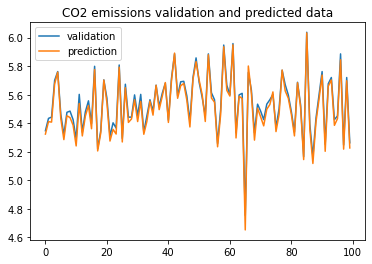

In [58]:
plt.plot(range(100), y_val[:100], label='validation')
plt.plot(range(100), xgb_pred[:100], label='prediction')
plt.title('CO2 emissions validation and predicted data')
plt.legend()

Apply np.expm1() function to our target data to get real values

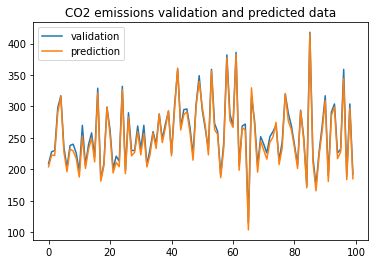

In [59]:
plt.plot(range(100), np.expm1(y_val[:100]), label='validation')
plt.plot(range(100), np.expm1(xgb_pred[:100]), label='prediction')
plt.title('CO2 emissions validation and predicted data')
plt.legend()

#### Hyperparameters tuning for XGBoost Regressor

In [60]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [61]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8,
    'seed': 13,
    'verbosity': 1,
}
xgboost = xgb.train(xgb_params, dtrain, num_boost_round=50, 
                    verbose_eval=5, evals=watchlist)

In [62]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [63]:
df_score_xgb = parse_xgb_output(output)

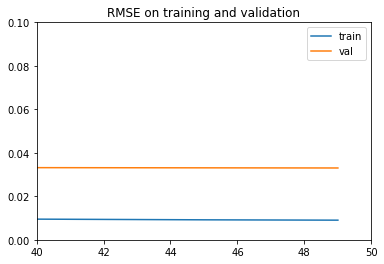

In [64]:
plt.plot(df_score_xgb.num_iter, df_score_xgb.train_rmse, label='train')
plt.plot(df_score_xgb.num_iter, df_score_xgb.val_rmse, label='val')
plt.title('RMSE on training and validation')
plt.xlim(40, 50)
plt.ylim(0, 0.1)
plt.legend()

##### eta tuning

In [65]:
scores = {}

In [72]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6, 
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8,
    'seed': 13,
    'verbosity': 1,
}
xgboost = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                    verbose_eval=5, evals=watchlist)

In [73]:
key = f'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [74]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.02', 'eta=0.05', 'eta=0.1'])

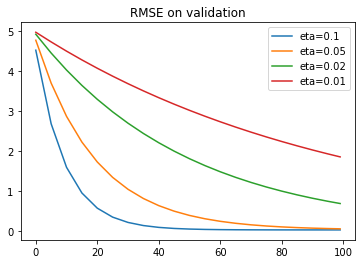

In [75]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.02', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
plt.title('RMSE on validation')
plt.legend()

In [76]:
eta = 0.1

##### max_depth tuning

In [77]:
scores = {}

In [86]:
%%capture output

xgb_params = {
    'eta': eta,
    'max_depth': 10, 
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8,
    'seed': 13,
    'verbosity': 1,
}
xgboost = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                    verbose_eval=5, evals=watchlist)

In [87]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

In [88]:
scores.keys()

dict_keys(['max_depth=1', 'max_depth=2', 'max_depth=5', 'max_depth=10'])

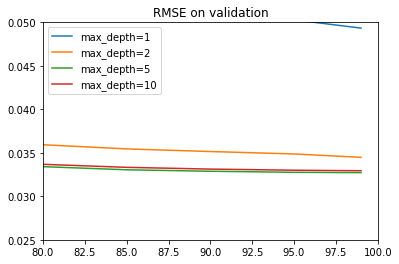

In [89]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=max_depth)
    plt.title('RMSE on validation')
plt.ylim(0.025, 0.05)
plt.xlim(80, 100)
plt.legend()

In [90]:
max_depth = 5

##### min_child_weight tuning

In [91]:
scores = {}

In [104]:
%%capture output

xgb_params = {
    'eta': eta,
    'max_depth': max_depth, 
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8,
    'seed': 13,
    'verbosity': 1,
}
xgboost = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                    verbose_eval=5, evals=watchlist)

In [105]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

In [106]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=2', 'min_child_weight=5', 'min_child_weight=10', 'min_child_weight=15', 'min_child_weight=20', 'min_child_weight=30'])

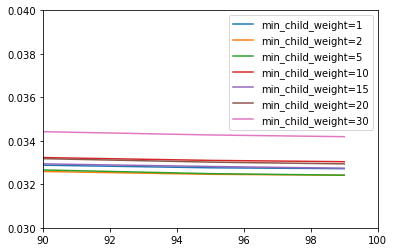

In [107]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=min_child_weight)
plt.xlim(90, 100)
plt.ylim(0.03, 0.04)
plt.legend()

In [108]:
min_child_weight = 5

In [109]:
xgb_params = {
    'eta': eta,
    'max_depth': max_depth, 
    'min_child_weight': min_child_weight,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8,
    'seed': 13,
    'verbosity': 1
}
xgboost = xgb.train(xgb_params, dtrain, num_boost_round=100)
xgb_pred = xgboost.predict(dval)
xgb_rmse = round(mean_squared_error(y_val, xgb_pred, squared=False), 4)
print(f'RMSE metric for best XGBoost: {xgb_rmse}')

RMSE metric for best XGBoost: 0.0324


### Linear Regression with Keras (TensorFlow)

In [110]:
X_train.shape

(4431, 51)

#### Baseline Model

In [111]:
inputs = keras.layers.Input(shape=(51,))

outputs = keras.layers.Dense(1)(inputs)

model = keras.Model(inputs, outputs)

learning_rate = 0.2
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

2021-12-05 12:46:52.751974: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [112]:
history = model.fit(
    X_train, y_train, 
    batch_size=1024, 
    epochs=100, 
    verbose=0,
    validation_data=(X_val, y_val), 
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]
  0%|                                                                                                                      | 0/100 [00:00<?, ?epoch/s]
  0%|                                                                                                                  | 0.00/5.00 [00:00<?, ?batch/s]
  1%|▏                  | 1/100 [00:00<00:41,  2.36epoch/s, loss=14.6, root_mean_squared_error=3.83, val_loss=0.42, val_root_mean_squared_error=0.648]
  0%|                                                                         | 0.00/5.00 [00:00<?, ?batch/s, loss=14.6, root_mean_squared_error=3.83]
  0%|                                                                       | 0.00/5.00 [00:00<?, ?batch/s, loss=0.985, root_mean_squared_error=0.992]
  0%|                                                                            | 0.00/5.00 [00:00<?, ?batch/s, loss=4.01, root_mean_squared_error=2]
  0%|                                                                

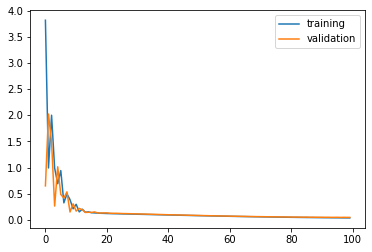

In [113]:
plt.plot(range(100), history.history['root_mean_squared_error'], label='training')
plt.plot(range(100), history.history['val_root_mean_squared_error'], label='validation')
plt.legend()

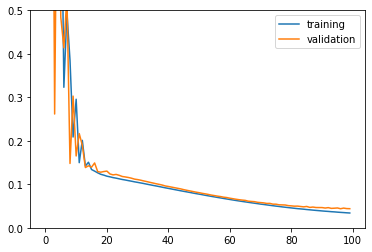

In [114]:
plt.plot(range(100), history.history['root_mean_squared_error'], label='training')
plt.plot(range(100), history.history['val_root_mean_squared_error'], label='validation')
plt.ylim(0.0, 0.5)
plt.legend()

In [115]:
tf_rmse = round(history.history['val_root_mean_squared_error'][-1], 4)
print(f'RMSE metric for baseline Regression with Keras: {tf_rmse}')

RMSE metric for baseline Regression with Keras: 0.044


#### Hyperparameters tuning for Regression with Keras (TensorFlow)

##### Adding more layers

In [116]:
inputs = keras.layers.Input(shape=(51,))

inner = keras.layers.Dense(30, activation='relu')(inputs)

outputs = keras.layers.Dense(1)(inner)

model = keras.Model(inputs, outputs)

learning_rate = 0.1
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

In [117]:
history = model.fit(
    X_train, y_train, 
    batch_size=1024, 
    epochs=100, 
    verbose=0,
    validation_data=(X_val, y_val)
)

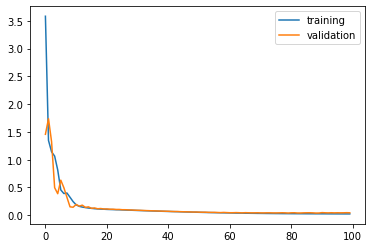

In [118]:
plt.plot(range(100), history.history['root_mean_squared_error'], label='training')
plt.plot(range(100), history.history['val_root_mean_squared_error'], label='validation')
plt.legend()

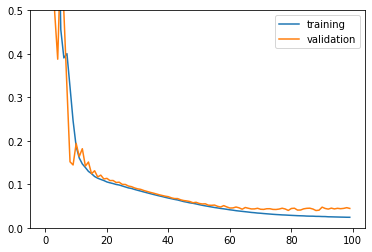

In [119]:
plt.plot(range(100), history.history['root_mean_squared_error'], label='training')
plt.plot(range(100), history.history['val_root_mean_squared_error'], label='validation')
plt.ylim(0.0, 0.5)
plt.legend()

In [120]:
tf_rmse = round(history.history['val_root_mean_squared_error'][-1], 4)
print(f'RMSE metric for Regression with Keras (adding more layers): {tf_rmse}')

RMSE metric for Regression with Keras (adding more layers): 0.0446


##### Adding Dropout

In [121]:
inputs = keras.layers.Input(shape=(51,))

inner = keras.layers.Dense(30, activation='relu')(inputs)
drop = keras.layers.Dropout(0.2)(inner)

outputs = keras.layers.Dense(1)(drop)

model = keras.Model(inputs, outputs)

learning_rate = 0.1
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

In [122]:
history = model.fit(
    X_train, y_train, 
    batch_size=1024, 
    epochs=100, 
    verbose=0,
    validation_data=(X_val, y_val)
)

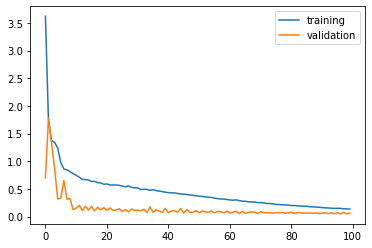

In [123]:
plt.plot(range(100), history.history['root_mean_squared_error'], label='training')
plt.plot(range(100), history.history['val_root_mean_squared_error'], label='validation')
plt.legend()

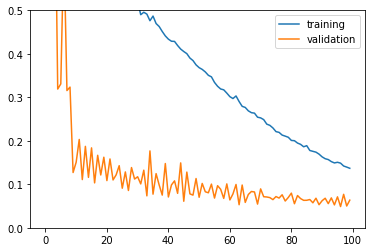

In [124]:
plt.plot(range(100), history.history['root_mean_squared_error'], label='training')
plt.plot(range(100), history.history['val_root_mean_squared_error'], label='validation')
plt.ylim(0.0, 0.5)
plt.legend()

In [125]:
tf_rmse = round(history.history['val_root_mean_squared_error'][-1], 4)
print(f'RMSE metric for Regression with Keras (dropout): {tf_rmse}')

RMSE metric for Regression with Keras (dropout): 0.0636


##### Use SGD optimizer

In [126]:
inputs = keras.layers.Input(shape=(51,))

outputs = keras.layers.Dense(1)(inputs)

model = keras.Model(inputs, outputs)

learning_rate = 0.1
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
rmse = keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=[rmse])

In [127]:
history = model.fit(
    X_train, y_train, 
    batch_size=1024, 
    epochs=600, 
    verbose=0,
    validation_data=(X_val, y_val)
)

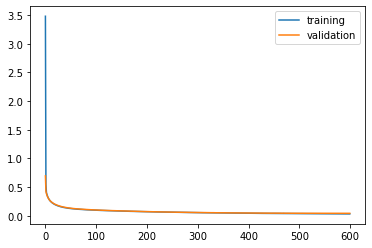

In [128]:
plt.plot(range(600), history.history['root_mean_squared_error'], label='training')
plt.plot(range(600), history.history['val_root_mean_squared_error'], label='validation')
plt.legend()

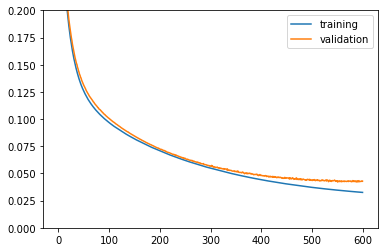

In [129]:
plt.plot(range(600), history.history['root_mean_squared_error'], label='training')
plt.plot(range(600), history.history['val_root_mean_squared_error'], label='validation')
plt.ylim(0.0, 0.2)
plt.legend()

In [130]:
tf_rmse = round(history.history['val_root_mean_squared_error'][-1], 4)
print(f'RMSE metric for Regression with Keras (SGD optimizer): {tf_rmse}')

RMSE metric for Regression with Keras (SGD optimizer): 0.0429


## Selecting the best model

In [131]:
model_df = pd.DataFrame(data=[('linear_regression', lr_rmse), 
                              ('ridge_regression', rr_rmse), 
                              ('random_forest_regressor', rf_rmse), 
                              ('xgboost_regressor', xgb_rmse), 
                              ('tf_keras_regressor', tf_rmse)],
                        columns=['model', 'rmse'])

In [132]:
model_df.sort_values(by='rmse')

,model,rmse
3,xgboost_regressor,0.0324
2,random_forest_regressor,0.0394
4,tf_keras_regressor,0.0429
1,ridge_regression,0.0480
0,linear_regression,0.0495


### Training the best model on full train dataset

In [133]:
df_full_train[['engine_size(l)', 
               'fuel_consumption_comb_(l/100_km)', 
               'fuel_consumption_comb_(mpg)']] = scaler.fit_transform(df_full_train[['engine_size(l)', 
                                                                                     'fuel_consumption_comb_(l/100_km)', 
                                                                                     'fuel_consumption_comb_(mpg)']])

full_train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)

y_full_train = np.log1p(y_full_train)

In [134]:
df_test[['engine_size(l)', 
          'fuel_consumption_comb_(l/100_km)', 
          'fuel_consumption_comb_(mpg)']] = scaler.fit_transform(df_test[['engine_size(l)', 
                                                                           'fuel_consumption_comb_(l/100_km)', 
                                                                           'fuel_consumption_comb_(mpg)']])

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

y_test = np.log1p(y_test)

#### Training the best XGBoost Regressor

In [135]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.get_feature_names())

In [136]:
xgb_params = {
    'eta': eta,
    'max_depth': max_depth, 
    'min_child_weight': min_child_weight,
    
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'nthread': 8,
    'seed': 13,
    'verbosity': 1
}
xgboost = xgb.train(xgb_params, dfulltrain, num_boost_round=44)
xgb_pred = xgboost.predict(dtest)
xgb_rmse = round(mean_squared_error(y_test, xgb_pred, squared=False), 4)
print(f'RMSE metric for best model (XGBoost) trained on full train dataset: {xgb_rmse}')

RMSE metric for best model (XGBoost) trained on full train dataset: 0.0247


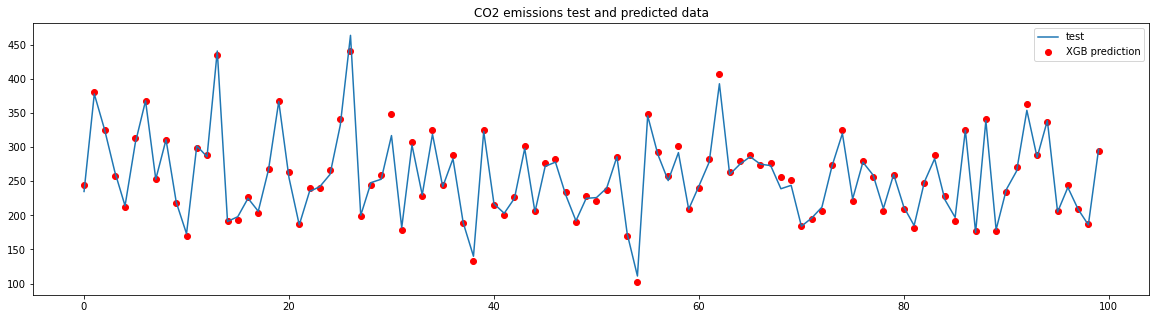

In [137]:
_, axes = plt.subplots(figsize=(20, 5))
plt.plot(range(100), np.expm1(y_test[100:200]), label='test')
plt.scatter(range(100), np.expm1(xgb_pred[100:200]), label='XGB prediction', color='red')
plt.title('CO2 emissions test and predicted data')
plt.legend()